# SPEECH/MUSIC DISCRIMINATION DASHBOARD

### Plotting Methods

In [ ]:
"""
!pip install requests
!pip install cherrypy
!pip install redis
!pip install paho-mqtt
!pip install matplotlib
!pip install scipy
"""

'\n!pip install requests\n!pip install cherrypy\n!pip install redis\n!pip install paho-mqtt\n!pip install matplotlib\n!pip install scipy\n'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from datetime import datetime

def format_timestamps(timestamps):
    formatted_timestamps = []
    for timestamp in timestamps:
        dt = datetime.fromtimestamp(timestamp)
        formatted_timestamps.append(dt.strftime("%H:%M:%S"))
    return formatted_timestamps

def sample(array):
    if len(array) > 20 and len(array) < 50: 
        indices = np.linspace(0, len(array) - 1, 5, dtype=int)
        return np.array(array)[indices]
    elif len(array) > 50:
        indices = np.linspace(0, len(array) -1, 10, dtype=int)
        return np.array(array)[indices]
    else:
        return array

def find_sign_change_indices(arr):
    indices = []
    sign = []
    for i in range(1, len(arr)):
        if(arr[i] * arr[i - 1] < 0):
            indices.append(i)
            sign.append(arr[i] > arr[i - 1])
    return indices, sign  

def plot_environment_control(timestamps, values, legend_1, legend_2, title:str = '', second_title:str = '',cmap: str = "RdYlGn", window=10):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
    
    expanded_timestamps = []
    for i in range(len(timestamps) - 1):
        expanded_timestamps.extend(np.interp(np.linspace(0, 1, 100), [0, 1], [timestamps[i], timestamps[i + 1]]))

    X_ = expanded_timestamps

    c = []
    for val in values:
        k = 0
        if val > 0:
            k = val - 0.48
        elif val < 0:
            k = val + 0.48
        c.append(k)
    
    expanded_values = []
    for i in range(len(c) - 1):
        expanded_values.extend(np.interp(np.linspace(0, 1, 100), [0, 1], [c[i], c[i + 1]]))
    Y_ = expanded_values

    c = sample(timestamps)
    formatted_timestamps = format_timestamps(c)
    # formatted_timestamps = sample(formatted_timestamps)
    normalized_values = (np.array(Y_) - np.min(Y_)) / 1.04
    n = np.linspace(-0.52, 0.52, len(Y_))
    cmap = plt.cm.get_cmap(cmap)
    colors = [cmap(i) for i in normalized_values]
    # plt.plot(X_, Y_)
    ax1.scatter(X_, Y_, c=normalized_values, cmap=cmap, alpha=0.4, s=4)

    ax1.fill_between(X_, 0.02, 0.22, color='red', alpha=0.1)
    ax1.fill_between(X_, -0.22, -0.02, color='red', alpha=0.1)

    moving_avg = np.convolve(Y_, np.ones(window)/window, mode='same')
    change_env, sign = find_sign_change_indices(moving_avg)
    ax1.plot(X_, moving_avg, color='blue', linestyle='--', label='Moving Average')


    ax1.set_xticks(c, formatted_timestamps, rotation=45) 
    ax1.set_yticks([-0.52, 0, 0.52], ["Speech", "Silence", "Music"])

    ax1.set_xlabel("Timestamp")
    # plt.ylabel("Valori")
    if title != '':
        ax1.set_title(title)
    if second_title != '':
        ax2.set_title(second_title)
    # plt.grid(True)

    ax1.set_xlim(min(timestamps), max(timestamps))
    fig.tight_layout()

    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)

    legend = [
        plt.Rectangle((0, 0), 1, 1, facecolor="yellow", alpha=0.5, label=legend_1),
        plt.Rectangle((0, 0), 1, 1, facecolor="blue", alpha=0.5, label=legend_2),
    ]
    ax2.legend(handles=legend)
    
    change_env.insert(0, 0)
    sign.insert(0, True)
    for i in range(1, len(change_env)):
        band_color = 'lightgray'
        if sign[i]:
            band_color = 'yellow'
        else:
            band_color = 'blue'
        ax2.axvspan(X_[change_env[i - 1]], X_[change_env[i]], facecolor=band_color, alpha=0.5)

    # Print last section
    s = not Y_[len(Y_) - 1] > 0
    bc = 'lightgray'
    if s:
        bc = 'yellow'
    else:
        bc = 'blue'
    ax2.axvspan(X_[change_env[len(change_env) - 1]], X_[len(X_) - 1], facecolor=bc, alpha=0.5)
    ax2.set_xlim(min(timestamps), max(timestamps))
    ax2.set_xticks([])
    ax2.set_yticks([])
    # Visualizzazione del grafico
    plt.show()

In [ ]:
import requests
import json

SERVER_ENDPOINT = "https://1e190a0d-e0c4-4d69-ad9e-7a1f03e6c992.deepnoteproject.com/"
SERVER_URI = "sensor/"

def fetch_data(sensor_name: str):

    try:
        response = requests.get(SERVER_ENDPOINT + SERVER_URI +  sensor_name)
        response.raise_for_status()  
        data = response.json()
        data = json.loads(data)
        data = data["values"]
        timestamps = []
        values = []
        for v in data:
            timestamps.append(v["timestamp"])
            values.append(float(v["value"]))
        return timestamps, values 
    except requests.exceptions.RequestException as e:
        print(f"Error occurred: {e}")
        return None


## Use Cases

### Environment control

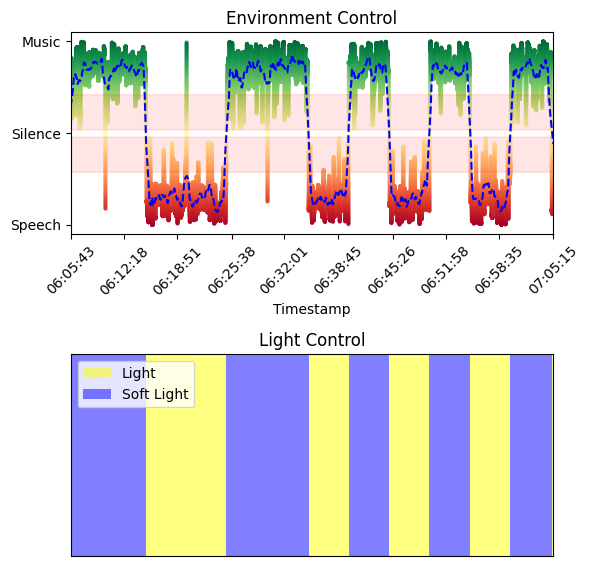

In [ ]:
t, v = fetch_data("s3")
plot_environment_control(t, v, legend_1="Light", legend_2 = "Soft Light", title="Environment Control", second_title='Light Control', window = 1000)

### Smart noise canceling

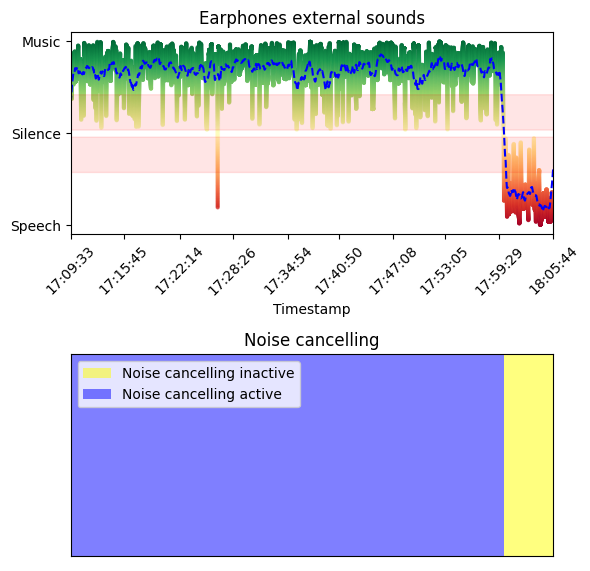

In [ ]:
t, v = fetch_data("s4")
plot_environment_control(t, v, legend_1="Noise cancelling inactive", legend_2 = "Noise cancelling active", title="Earphones external sounds", second_title='Noise cancelling', window = 1000)

### Attention signal during long car trip

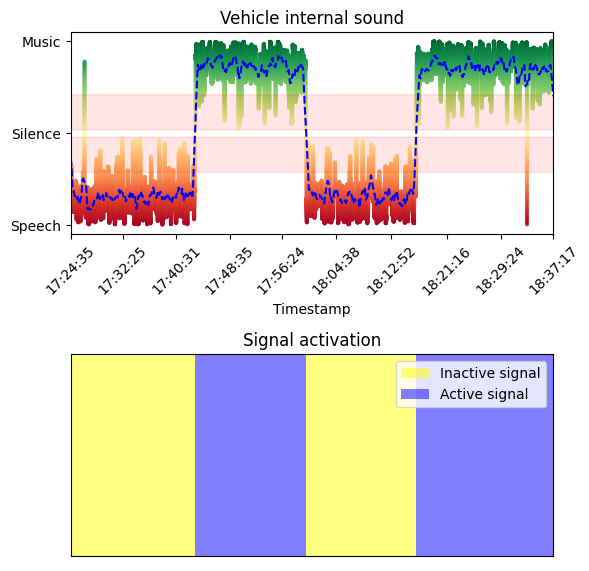

In [ ]:
t, v = fetch_data("s5")
plot_environment_control(t, v, legend_1="Inactive signal", legend_2 = "Active signal", title="Vehicle internal sound", second_title='Signal activation', window = 1000)

### 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1e190a0d-e0c4-4d69-ad9e-7a1f03e6c992' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>